<a href="https://colab.research.google.com/github/ozaayy/Satis_Tahmin_Streamlit/blob/main/PROJE_Ma%C4%9Faza_Zinciri_%C4%B0%C3%A7in_Talep_Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing Libraries and Setting Seeds

In [40]:
import random, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import date
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

# Function Definitions

In [41]:
def load_and_preprocess(data_path):
    data = pd.read_csv(data_path)
    data['temp_celsius'] = data['temp'] - 273.15
    data['date'] = pd.to_datetime(data['dt_iso']).dt.date
    data = data.drop(columns=['dt_iso', 'temp'])
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    return data.resample('D').mean()

def split_data_by_time(df, train_frac=0.7, val_frac=0.15):
    n = len(df)
    train_size = int(n * train_frac)
    val_size = int(n * val_frac)
    test_size = n - train_size - val_size
    train_df = df[:train_size]
    val_df = df[train_size:train_size+val_size]
    test_df = df[train_size+val_size:]
    return train_df, val_df, test_df


def scale_data(train_df, val_df, test_df, feature_columns, target_column):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_x.fit(train_df[feature_columns])
    scaler_y.fit(train_df[[target_column]])
    train_x = scaler_x.transform(train_df[feature_columns])
    val_x = scaler_x.transform(val_df[feature_columns])
    test_x = scaler_x.transform(test_df[feature_columns])
    train_y = scaler_y.transform(train_df[[target_column]])
    val_y = scaler_y.transform(val_df[[target_column]])
    test_y = scaler_y.transform(test_df[[target_column]])
    return train_x, val_x, test_x, train_y.flatten(), val_y.flatten(), test_y.flatten(), scaler_x, scaler_y

def create_timewindow(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys), time_steps


def evaluate_predictions(model, X_train, y_train, X_val, y_val, X_test, y_test, scaler_y):

    y_train_pred_ = model.predict(X_train, verbose=0)
    y_val_pred = model.predict(X_val, verbose=0)
    # y_test_pred is calculated for prediction, not evaluation against true values
    y_test_pred = model.predict(X_test, verbose=0)


    true_y_train_pred = scaler_y.inverse_transform(y_train_pred_)
    true_y_val_pred = scaler_y.inverse_transform(y_val_pred)
    true_y_test_pred = scaler_y.inverse_transform(y_test_pred) # Keep this for plotting/submission


    true_y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1))
    true_y_val = scaler_y.inverse_transform(y_val.reshape(-1, 1))
    # We don't have true_y_test for the actual test set, so we cannot inverse scale it
    # and we cannot calculate MSE for the actual test set.


    train_mse = mean_squared_error(true_y_train, true_y_train_pred)
    val_mse = mean_squared_error(true_y_val, true_y_val_pred)
    # test_mse cannot be calculated for the actual test set where true values are NaN
    test_mse = float('nan') # Assign NaN or some indicator

    print("Train MSE:", train_mse, "Validation MSE:", val_mse, "Test MSE:", test_mse)
    # Return None or handle the missing true_y_test appropriately in the return value
    # For consistency, return y_test as is (which contains NaNs if the original test set had them)
    return true_y_train, true_y_train_pred, true_y_val, true_y_val_pred, y_test, true_y_test_pred, train_mse, val_mse, test_mse


def prepare_sales_data(train_data_path, test_data_path):
    """
    Eğitim ve test veri setlerini yükler, birleştirir ve özellik mühendisliği uygular.

    Args:
        train_data_path (str): Eğitim veri setinin dosya yolu.
        test_data_path (str): Test veri setinin dosya yolu.

    Returns:
        tuple: İşlenmiş birleşik DataFrame (pd.DataFrame),
               özellik sütunlarının listesi (list),
               hedef sütunun adı (str).
    """

    # Veri setlerini yükle
    df_train = pd.read_csv(train_data_path)
    df_test = pd.read_csv(test_data_path)

    # 'sales' sütununu test setinden kaldır (eğer varsa)
    if 'sales' in df_test.columns:
        df_test = df_test.drop(columns=['sales'])

    # Birleştirme öncesi index'i resetleyelim (eğer gerekliyse, burada zaten yok)
    # df_train.reset_index(inplace=True) # Not needed if index is not date yet
    # df_test.reset_index(inplace=True) # Not needed if index is not date yet

    # İki veri setini birleştir
    # df_test does not have 'id' column as per problem description, assuming 'id' is only for submission matching test data.
    # Let's add an 'id' column to train data initialized with NaN for consistency during concatenation.
    if 'id' not in df_train.columns:
         df_train['id'] = np.nan


    # Ensure columns are consistent before concat (e.g., 'id')
    # Ensure all columns in train and test are aligned if not perfectly matched by default concat
    # For simplicity, let's just concat and handle missing columns (like id in train) afterwards

    df_combined = pd.concat([df_train, df_test], ignore_index=True, sort=False) # Use sort=False to avoid sorting columns


    # 'date' sütununu datetime formatına dönüştür ve indeksi ayarla
    df_combined['date'] = pd.to_datetime(df_combined['date'])
    df_combined.sort_values(by=['date', 'store', 'item'], inplace=True) # Sort by date, then store, then item for correct rolling/lag calculations
    df_combined.set_index('date', inplace=True)

    # --- Temel Zaman Tabanlı Özellikler ---
    df_combined['year'] = df_combined.index.year
    df_combined['month'] = df_combined.index.month
    df_combined['day'] = df_combined.index.day
    df_combined['dayofweek'] = df_combined.index.dayofweek
    df_combined['dayofyear'] = df_combined.index.dayofyear
    # Ensure weekofyear is handled correctly for start/end of year weeks
    # Use .isocalendar().week which is more robust for week number calculation
    df_combined['weekofyear'] = df_combined.index.isocalendar().week.astype(int)
    df_combined['quarter'] = df_combined.index.quarter
    df_combined['is_weekend'] = (df_combined.index.dayofweek >= 5).astype(int)

    # --- Daha Fazla Zaman Dilimi Özellikleri ---
    #df_combined['dayofmonth'] = df_combined.index.day
    #df_combined['weekofmonth'] = (df_combined.index.day - 1) // 7 + 1
    #df_combined['month_start'] = (df_combined.index.is_month_start).astype(int)
    #df_combined['month_end'] = (df_combined.index.is_month_end).astype(int)
    #df_combined['year_start'] = (df_combined.index.is_year_start).astype(int)
    #df_combined['year_end'] = (df_combined.index.is_year_end).astype(int)
    #df_combined['quarter_start'] = (df_combined.index.is_quarter_start).astype(int)
    #df_combined['quarter_end'] = (df_combined.index.is_quarter_end).astype(int)

    # --- Mevsimsel Özellikler (sinüzoidal dönüşüm) ---
    #df_combined['sin_dayofyear'] = np.sin(2 * np.pi * df_combined['dayofyear'] / 365.25)
    #df_combined['cos_dayofyear'] = np.cos(2 * np.pi * df_combined['dayofyear'] / 365.25)
    # Note: Division by 31 for dayofmonth can sometimes be inaccurate, consider using dayofyear conversion
    # df_combined['sin_dayofmonth'] = np.sin(2 * np.pi * df_combined['day'] / 31)
    # df_combined['cos_dayofmonth'] = np.cos(2 * np.pi * df_combined['day'] / 31)
    #df_combined['sin_dayofweek'] = np.sin(2 * np.pi * df_combined['dayofweek'] / 7)
    #df_combined['cos_dayofweek'] = np.cos(2 * np.pi * df_combined['dayofweek'] / 7)
    # Note: Division by 52 for weekofyear is an approximation, might need refinement
    #df_combined['sin_weekofyear'] = np.sin(2 * np.pi * df_combined['weekofyear'] / 52)
    #df_combined['cos_weekofyear'] = np.cos(2 * np.pi * df_combined['weekofyear'] / 52)
    #df_combined['sin_month'] = np.sin(2 * np.pi * df_combined['month'] / 12)
    #df_combined['cos_month'] = np.cos(2 * np.pi * df_combined['month'] / 12)

    # --- Tatil Günleri Etkisi (Örnek Tatiller) ---
    # Gerçek tatil verisi için 'holidays' kütüphanesi kullanılabilir.
    df_combined['is_new_year_day'] = ((df_combined.index.month == 1) & (df_combined.index.day == 1)).astype(int)
    # Add other specific holidays if known for the dataset's region
    # df_combined['is_christmas'] = ((df_combined.index.month == 12) & (df_combined.index.day == 25)).astype(int)


    # --- ROLLING VE LAG ÖZELLİKLERİNİ HESAPLAMA (ONE-HOT ENCODING'DEN ÖNCE) ---
    # Calculate rolling/lag features using original 'store' and 'item' before one-hot encoding

    windows =  [7, 30]       #Alternative parameters ----[7, 14, 30, 90, 365]------#
    for window in windows:
        # Use groupby on 'store' and 'item' (which still exist here)
        df_combined[f'sales_rolling_mean_{window}d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window).mean())
        df_combined[f'sales_rolling_median_{window}d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window).median())
        df_combined[f'sales_rolling_std_{window}d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window).std())
        df_combined[f'sales_rolling_min_{window}d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window).min())
        df_combined[f'sales_rolling_max_{window}d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window=window).max())

    df_combined['sales_lag_365d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(365))
    df_combined['sales_lag_30d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(30))
    df_combined['sales_lag_7d'] = df_combined.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(7))

    # --- Kategorik Değişkenleri İşleme (One-Hot Encoding) ---
    # Now apply One-Hot Encoding after rolling/lag calculations

    # Use pd.get_dummies on 'store' and 'item'. The original columns will be dropped.
    df_combined = pd.get_dummies(df_combined, columns=['store', 'item'], drop_first=True)

    # --- Etkileşim Özellikleri ---
    # Re-create interaction features if needed, now using the one-hot encoded columns if desired,
    # or keep simple interactions with numerical/sinusoidal features.
    # Keeping the simple interaction with month and dayofweek as it does not depend on 'store' or 'item'
    df_combined['month_dayofweek_interaction'] = df_combined['month'] * (df_combined['dayofweek'] + 1)


    # Özellikler ve hedef değişkeni tanımla
    # Şimdi One-Hot encoded sütunlar feature_columns listesine otomatik dahil olacaktır.
    # 'id' sütununu hala hariç tutuyoruz, bu sadece test seti için önemli.
    feature_columns = [col for col in df_combined.columns if col not in ['sales', 'id']]
    target_column = 'sales'

    print(f"Toplam özellik sayısı (model girdisi): {len(feature_columns)}")
    print(f"Toplam sütun sayısı (sales ve id dahil): {len(df_combined.columns)}")
    # print("\nOluşturulan Özellikler:")
    # print(feature_columns) # Debugging için faydalı olabilir

    return df_combined, feature_columns, target_column


def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE).

    Args:
        y_true (np.ndarray): True values.
        y_pred (np.ndarray): Predicted values.

    Returns:
        float: The SMAPE value.
    """
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Handle cases where both true and predicted values are zero to avoid NaN/Inf
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Use a small epsilon or mask for cases where denominator is zero
    # Avoid division by zero: if denominator is zero, and numerator is also zero, the term is 0.
    # If denominator is zero but numerator is not, this shouldn't happen with real data,
    # but to be safe, handle division by zero.
    smape_term = np.zeros_like(y_true, dtype=np.float64) # Use float64 for precision
    non_zero_mask = denominator != 0
    smape_term[non_zero_mask] = np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) / denominator[non_zero_mask]

    # Ensure to handle potential NaN/Inf from original data or if a term somehow results in it
    # Although with the zero denominator handling, this should be less likely for the term itself.
    # If y_true contains NaNs, they will propagate. We assume y_true for validation set is clean.

    return np.mean(smape_term) * 100.0 # Return as percentage



# DATA PREPARATION

Data Preparation:
1- Başlangıçta verilen train ve test veri setlerini concat metodu ile birleştirildi.
2- Bu aşamada, her iki veri setini birleştirerek, birleşik veri seti üzerinde değişken oluşturma ve veri işleme adımlarını gerçekleştirildi.
3- Zaman serisi verilerini analiz edildi ve mevsimsel etkileri, tatil günlerini, promosyon dönemleri vs. dikkate
alınarak özellik mühendisliği uygulandı.
4- 60 yeni değişken oluşturularak veri seti genişletildi. Örneğin, yıl, ay, hafta içi/hafta sonu etkisi, tatil günleri için değişkenler eklendi.

In [42]:
data_path_test= "/content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/test.csv"

In [43]:
data_path_train= "/content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/train.csv"

In [49]:
# @title Loading Dataset & Adding Feature Columns

df_processed, feature_cols, target_col = prepare_sales_data(data_path_train, data_path_test)

# İşlenmiş DataFrame'i göster
print(df_processed.head())

# Özellik sütunlarının listesini görebilirsiniz
print("Feature Columns:", feature_cols)

# Hedef sütunun adını görebilirsiniz
print("Target Columns:",target_col)


Toplam özellik sayısı (model girdisi): 81
Toplam sütun sayısı (sales ve id dahil): 83
            sales  id  year  month  day  dayofweek  dayofyear  weekofyear  \
date                                                                        
2013-01-01   13.0 NaN  2013      1    1          1          1           1   
2013-01-01   33.0 NaN  2013      1    1          1          1           1   
2013-01-01   15.0 NaN  2013      1    1          1          1           1   
2013-01-01   10.0 NaN  2013      1    1          1          1           1   
2013-01-01   11.0 NaN  2013      1    1          1          1           1   

            quarter  is_weekend  ...  item_42  item_43  item_44  item_45  \
date                             ...                                       
2013-01-01        1           0  ...    False    False    False    False   
2013-01-01        1           0  ...    False    False    False    False   
2013-01-01        1           0  ...    False    False    False    Fal

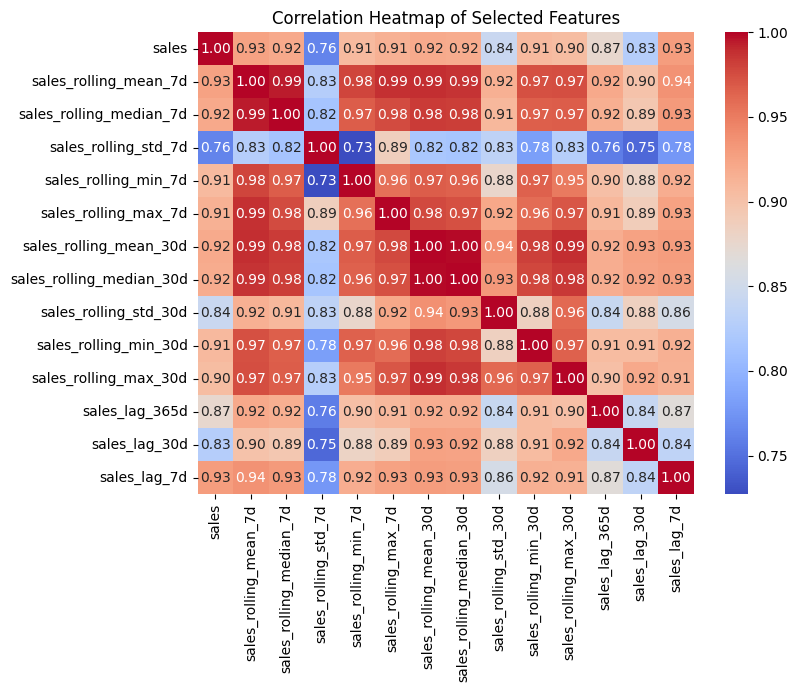

In [55]:
# Display the plot
plt.show()

# Belirli sütunları seçin
#selected_columns = ['sales', 'item_2', 'item_3', 'item_4', 'item_5', 'item_6', 'item_7', 'item_8', 'item_9', 'item_10', 'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_30', 'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38', 'item_39', 'item_40', 'item_41', 'item_42', 'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49', 'item_50']
#selected_columns = ['sales', 'store_3', 'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 'store_9', 'store_10']
selected_columns = ['sales', 'sales_rolling_mean_7d', 'sales_rolling_median_7d', 'sales_rolling_std_7d', 'sales_rolling_min_7d', 'sales_rolling_max_7d', 'sales_rolling_mean_30d', 'sales_rolling_median_30d', 'sales_rolling_std_30d', 'sales_rolling_min_30d', 'sales_rolling_max_30d', 'sales_lag_365d', 'sales_lag_30d', 'sales_lag_7d']

df_selected = df_processed[selected_columns]

# Seçilen sütunlar arasındaki korelasyon matrisini hesaplayın
correlation_matrix_selected = df_selected.corr()

# Heatmap'i oluşturun (isteğe bağlı olarak annot=True yapabilirsiniz)
plt.figure(figsize=(8, 6)) # Heatmap boyutunu ayarlayın
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f")

# Başlığı ayarlayın
plt.title('Correlation Heatmap of Selected Features')

# Plot'u gösterin
plt.show()


In [56]:
# @title Splitting the Combined Dataset into Training, Validation and Test Sets

# Birleştirilmiş veri setini zaman bazlı olarak eğitim, doğrulama ve test setlerine bölünmesi
# df_processed değişkeni, prepare_sales_data fonksiyonundan dönen işlenmiş DataFrame'i içerir.
train_df, val_df, test_df = split_data_by_time(df_processed, train_frac=0.7, val_frac=0.15)

# Modelin eğitileceği kısmındaki (train ve val) NaN 'sales' değerlerini düşür
# Yeni oluşturulan rolling/lag özelliklerinde NaN değerler olabilir.
# Bu NaN değerlerini düşürmek yerine doldurmak (örneğin 0 veya medyan ile) modelin daha fazla veri görmesini sağlayabilir.
# Burada sadece hedef değişken (sales) NaN olan satırları düşürüyoruz.
train_df.dropna(subset=[target_col], inplace=True) # Use target_col variable
val_df.dropna(subset=[target_col], inplace=True)   # Use target_col variable
# Test setindeki 'sales' sütununda zaten NaN beklenir.


# Özellik sütunlarındaki NaN değerleri doldurma (opsiyonel ama genellikle gerekli)
# Rolling ve lag özelliklerinde NaN değerler oluşabilir. Bunları dolduralım.
# Basitçe 0 ile doldurabiliriz veya train setinin ortalaması/medyanı ile doldurabiliriz.
# LSTM 0 değerlerini işleyebilir, bu yüzden basitlik için 0 kullanabiliriz.

for col in feature_cols: # Use feature_cols variable returned by prepare_sales_data
    if col in train_df.columns:
        train_df[col].fillna(0, inplace=True) # Eğitim verisindeki NaN'leri doldur
    if col in val_df.columns:
        val_df[col].fillna(0, inplace=True)   # Doğrulama verisindeki NaN'leri doldur
    if col in test_df.columns:
         test_df[col].fillna(0, inplace=True) # Test verisindeki NaN'leri doldur (özellikler için)


<ipython-input-56-1501058886>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(subset=[target_col], inplace=True) # Use target_col variable
<ipython-input-56-1501058886>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.dropna(subset=[target_col], inplace=True)   # Use target_col variable
<ipython-input-56-1501058886>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [18]:
# @title Data Scale and Time Window
# Veriyi ölçeklendir (güncellenmiş özellik listesi ile)
# Scaling'den önce NaN değerleri doldurduğumuzdan emin olun.
train_x, val_x, test_x, train_y, val_y, test_y, scaler_x, scaler_y = scale_data(
    train_df, val_df, test_df, feature_cols, target_col # Changed 'feature_columns' to 'feature_cols' and 'target_column' to 'target_col'
)

# Zaman penceresi oluştur
time_steps = 30 # Örnek bir zaman penceresi boyutu, bunu ihtiyacınıza göre ayarlayın
X_train, y_train, time_steps_train = create_timewindow(train_x, train_y, time_steps)
X_val, y_val, time_steps_val = create_timewindow(val_x, val_y, time_steps)
X_test, y_test, time_steps_test = create_timewindow(test_x, test_y, time_steps)

# input_shape artık X_train'in şekline göre belirlenebilir
input_shape = (X_train.shape[1], X_train.shape[2])

print("\nVeri hazırlığı ve özellik mühendisliği tamamlandı.")
print(f"Oluşturulan X_train boyutu: {X_train.shape}")
print(f"Oluşturulan X_val boyutu: {X_val.shape}")
print(f"Oluşturulan X_test boyutu: {X_test.shape}")


Veri hazırlığı ve özellik mühendisliği tamamlandı.
Oluşturulan X_train boyutu: (670570, 30, 81)
Oluşturulan X_val boyutu: (143670, 30, 81)
Oluşturulan X_test boyutu: (143670, 30, 81)


In [19]:
# @title Saving Scalers
# Define the paths where you want to save the scalers
scaler_x_save_path = '/content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/scaler_x.save'
scaler_y_save_path = '/content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/scaler_y.save'

# Save the scalers
joblib.dump(scaler_x, scaler_x_save_path)
joblib.dump(scaler_y, scaler_y_save_path)

print(f"Scaler_x saved to: {scaler_x_save_path}")
print(f"Scaler_y saved to: {scaler_y_save_path}")

Scaler_x saved to: /content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/scaler_x.save
Scaler_y saved to: /content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/scaler_y.save


# MODEL TRAINING

In [20]:
# Model input (30,64)
input_shape = (X_train.shape[1], X_train.shape[2])
input_shape

# HyperParameter Optimization New best SMAPE found: 42.2249 with params: {'optimizer': 'adam', 'learning_rate': 0.0001, 'gru_units': 50, 'batch_size': 32}

(30, 81)

In [21]:
# @title Model Scelethon

model = Sequential([
        GRU(50, input_shape=input_shape,
             kernel_regularizer=l2(0.001)),
        Dense(1)
    ])


optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mse'])

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │        19,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# @title Training
start_time = datetime.datetime.now()

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_val, y_val),
    batch_size=32,
    verbose=1,
    callbacks=early_stopping
)

end_time = datetime.datetime.now()

total_duration = end_time - start_time
print("Training Time:", total_duration)

Epoch 1/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 107s 5ms/step - loss: 0.0322 - mse: 0.0103 - val_loss: 0.0021 - val_mse: 0.0016
Epoch 2/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 0.0018 - mse: 0.0014 - val_loss: 0.0018 - val_mse: 0.0016
Epoch 3/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 0.0016 - mse: 0.0014 - val_loss: 0.0018 - val_mse: 0.0016
Epoch 4/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 102s 5ms/step - loss: 0.0015 - mse: 0.0014 - val_loss: 0.0017 - val_mse: 0.0016
Epoch 5/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 103s 5ms/step - loss: 0.0015 - mse: 0.0014 - val_loss: 0.0017 - val_mse: 0.0016
Epoch 6/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 0.0015 - mse: 0.0014 - val_loss: 0.0017 - val_mse: 0.0016
Epoch 7/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 0.0015 - mse: 0.0014 - val_loss: 0.0017 - val_mse: 0.0016
Epoch 8/1000
20956/20956 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - loss: 0.0015 - mse: 0.0014 - val_loss: 0.0017 - val_mse:

In [23]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
val_loss = model.evaluate(X_val, y_val, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss[0]}", f"Validation Loss: {val_loss[0]}", f"Test Loss: {test_loss[0]}")

Train Loss: 0.0012855544919148088 Validation Loss: 0.001418662373907864 Test Loss: nan


Trial 1: Adam // Train Loss: 0.016007063910365105 Validation Loss: 0.019472185522317886 Test Loss: 0.025481995195150375 RMSProp// Train Loss: 0.016178516671061516 Validation Loss: 0.019330497831106186 Test Loss: 0.024836385622620583

Trial 2: Adam // Train Loss: 0.013857847079634666 Validation Loss: 0.01610736921429634 Test Loss: nan (Combined data)

Trial 3: Adam - GRU //Train Loss: 0.013900409452617168 Validation Loss: 0.01612265594303608 Test Loss: nan. (Combined data)

Trial 4: Train Loss: 0.013920953497290611 Validation Loss: 0.01615520752966404 Test Loss: nan

Trial 5: Adam - GRU Train Loss: 0.013670507818460464 Validation Loss: 0.01580984517931938 Test Loss: nan

Trial 6: Train Loss: 0.013618783093988895 Validation Loss: 0.01576903462409973 Test Loss: nan

Trial 7: Train Loss: 0.0012855544919148088 Validation Loss: 0.001418662373907864 Test Loss: nan (after feature colummns change)

In [24]:
# @title Saving Model

model_save_path = '/content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/feature_optimised_model(GRU).keras' # Add the .keras extension

# Modeli TensorFlow SavedModel formatında kaydet
model.save(model_save_path)

print(f"Model başarıyla kaydedildi: {model_save_path}")

Model başarıyla kaydedildi: /content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/feature_optimised_model(GRU).keras


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │        19,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

# HYPERPARAMETER OPTIMIZATION

In [ ]:
# @title HyperParameter Optimization, Best Validation SMAPE , Tunings

# Assuming X_train, y_train, X_val, y_val, X_test, y_test,
# scaler_y, input_shape, and time_steps are already defined
# from previous data preparation steps.

In [35]:
# @title 1.Set Up Hyperparameter Tuning Combinations

# Define the optimizers and their corresponding learning rates to test
optimizer_configs = {
    'adam': [0.001, 0.0001], # Adam with different learning rates [0.001, 0.0005, 0.0001]
    # 'rmsprop': [0.001, 0.0001] # RMSprop with different learning rates [0.001, 0.0005, 0.0001]
}

# You can also vary other hyperparameters here, e.g.,:
gru_units = [50]
l2_lambda = [0.001, 0.0001, 0.00001] # l2 regularization strength (remains at 0.001 as not uncommented)
batch_sizes = [64]

# Create a list of all hyperparameter combinations to try
tuning_combinations = []
for opt_name, lrs in optimizer_configs.items():
    for lr in lrs:
        # Add other hyperparams here if tuning them
        # tuning_combinations.append({'optimizer': opt_name, 'learning_rate': lr}) # Original line, now replaced by nested loops
        # If varying units/l2/batch size:
        for units in gru_units:
            # for reg_lambda in l2_lambda: # l2_lambda is not uncommented, keeping it fixed at 0.001
            for batch_size in batch_sizes:
                tuning_combinations.append({
                    'optimizer': opt_name,
                    'learning_rate': lr,
                    'gru_units': units,
                    'l2_lambda': l2_lambda, # l2_lambda is not uncommented
                    'batch_size': batch_size
                })

In [36]:
# @title 2.Train and Evaluate in a Loop

# --- 4. Train and Evaluate in a Loop ---

best_smape = float('inf') # Initialize with a very high value
best_params = None
best_model = None
tuning_results = [] # To store results of each run

print(f"\nStarting hyperparameter tuning with {len(tuning_combinations)} combinations...")

for i, params in enumerate(tuning_combinations):
    print(f"\n--- Training combination {i+1}/{len(tuning_combinations)}: {params} ---")

    # --- Recreate and Compile Model ---
    # Define model architecture (can make units/l2 dynamic if tuning)
    model = Sequential([
            GRU(params['gru_units'], # Use params.get('gru_units', 50) if tuning units
                 input_shape=input_shape,
                 kernel_regularizer=l2(0.001)), # Use params.get('l2_lambda', 0.001) if tuning l2
            Dense(1)
        ])

    # Select optimizer based on config
    opt_name = params['optimizer']
    lr = params['learning_rate']

    if opt_name == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        raise ValueError(f"Unknown optimizer: {opt_name}")

    model.compile(optimizer=optimizer,
                  loss='mean_squared_error') # Continue monitoring MSE loss during training

    # Set up Early Stopping (can make patience dynamic if tuning)
    early_stopping = EarlyStopping(
        monitor='val_loss', # Monitor validation loss
        patience=5,       # Number of epochs with no improvement after which training will be stopped
        verbose=1,
        restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
    )

    # Get batch size (can make dynamic if tuning)
    batch_size = params['batch_size'] # Use params.get('batch_size', 32) if tuning batch size

    # --- Train the Model ---
    start_time = datetime.datetime.now()
    history = model.fit(
        X_train, y_train,
        epochs=1000, # Use a large number of epochs with EarlyStopping
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        verbose=1, # Set to 0 to hide training output per epoch
        callbacks=[early_stopping]
    )
    end_time = datetime.datetime.now()
    training_duration = end_time - start_time
    print(f"Training Duration: {training_duration}")


    # --- Evaluate SMAPE on Validation Set ---

    # 1. Make predictions on the validation set
    val_predictions_scaled = model.predict(X_val, verbose=0)

    # 2. Inverse scale the true and predicted validation values
    true_val_y = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
    predicted_val_y = scaler_y.inverse_transform(val_predictions_scaled).flatten()

    # 3. Calculate SMAPE
    current_smape = smape(true_val_y, predicted_val_y)

    print(f"Validation SMAPE: {current_smape:.4f}")

    # --- Record Results ---
    tuning_results.append({
        'params': params,
        'val_smape': current_smape,
        'training_duration': training_duration
        # Add other metrics if desired, e.g., val_loss from history
    })

    # --- Check for Best Model ---
    if current_smape < best_smape:
        best_smape = current_smape
        best_params = params
        best_model = model # Store the model object (can be large)
        print(f"New best SMAPE found: {best_smape:.4f} with params: {best_params}")

    # --- Check if SMAPE is below 13 ---
    if current_smape < 13.0:
        print(f"Successfully achieved Validation SMAPE < 13.0 with params: {params}")
        # You might choose to stop tuning here or continue to find the absolute best.
        # break # Uncomment to stop after the first successful combination


Starting hyperparameter tuning with 2 combinations...

--- Training combination 1/2: {'optimizer': 'adam', 'learning_rate': 0.001, 'gru_units': 50, 'l2_lambda': [0.001, 0.0001, 1e-05], 'batch_size': 64} ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 0.0116 - val_loss: 0.0020
Epoch 2/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 4/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 5/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 6/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
Training Duration: 0:06:48.656938
Validation SMAPE: 14.0584
New best SMAPE found: 14.0584 with params: {'optimizer': 'adam', 'learning_rate': 0.001, 'gru_units': 50, 'l2_lam

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - loss: 0.0353 - val_loss: 0.0026
Epoch 2/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 3/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 49s 5ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 5/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 7/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 11/1000
10478/10478 ━━━━━━━━━━━━━━━━━━━━ 48s 5ms/step - loss: 0

In [37]:
# @title 3.Identify the Best Model (after loop finishes)

print("\n--- Tuning Complete ---")
print(f"Best Validation SMAPE: {best_smape:.4f}")
print(f"Best Parameters: {best_params}")

# You can now use the best_model for final evaluation on the test set (if true test labels were available)
# or for making predictions on the actual unseen test data for submission.

# Optional: Save the best model
# if best_model:
#     best_model_save_path = '/content/drive/MyDrive/Colab Notebooks/Store Item Demand Forecasting Project/best_model_smape.keras'
#     best_model.save(best_model_save_path)
#     print(f"Best model saved to: {best_model_save_path}")

# Optional: Convert results to DataFrame for easier analysis
# results_df = pd.DataFrame(tuning_results)
# print("\nTuning Results Summary:")
# display(results_df.sort_values(by='val_smape').head())


--- Tuning Complete ---
Best Validation SMAPE: 13.3019
Best Parameters: {'optimizer': 'adam', 'learning_rate': 0.0001, 'gru_units': 50, 'l2_lambda': [0.001, 0.0001, 1e-05], 'batch_size': 64}


New best SMAPE found: 42.2249 with params: {'optimizer': 'adam', 'learning_rate': 0.0001, 'gru_units': 50, 'batch_size': 32}

# PREDICTION & ANALYSIS

In [38]:
# @title Final DataFrame Creation (Combined Train and Test with Predicted Data)

# This cell aims to create a single DataFrame containing:
# - All original train data columns + engineered features + actual 'sales'
# - All original test data columns + engineered features + predicted 'sales' (as 'sales_predicted')
# - The 'date' column as a standard column, not the index.
# - The 'id' column for test data entries (will be NaN for train entries).

# Ensure train_df and test_df (after feature engineering and splitting) are available.
# train_df contains actual sales, test_df contains NaN sales for the test period.

# --- 1. Prepare the Test DataFrame with Predictions ---

# Make predictions on the scaled test data (X_test)
# X_test was created using create_timewindow from scaled test_x.
# The predictions correspond to the data points in test_df starting from 'time_steps'.
test_predictions_scaled = model.predict(X_test, verbose=0)

# Inverse scale the predictions to original scale
test_predictions_original_scale = scaler_y.inverse_transform(test_predictions_scaled).flatten()

# The predictions align with the rows in test_df starting from the time_steps-th row.
# We need to create a 'sales_predicted' column in the *original* test_df.
# Initialize a column with NaN for the entire test_df first.
test_df_with_predictions = test_df.copy() # Work on a copy to avoid modifying the original test_df used elsewhere
test_df_with_predictions['sales_predicted'] = np.nan # Add the prediction column, initialized to NaN

# Assign the predicted values to the correct rows.
# The predicted values correspond to the rows from index 'time_steps' onwards
# in the X_test/y_test which were derived from test_df.
# So, we place the predictions starting from the 'time_steps' index in the test_df copy.
# The length of predictions is len(test_df) - time_steps.
test_df_with_predictions.iloc[time_steps: time_steps + len(test_predictions_original_scale),
                              test_df_with_predictions.columns.get_loc('sales_predicted')] = test_predictions_original_scale

# --- 2. Prepare Train and Test DataFrames for Concatenation ---

# Make 'date' a column in both DataFrames by resetting the index.
train_df_final = train_df.reset_index().copy() # Reset index and create a copy
test_df_final = test_df_with_predictions.reset_index().copy() # Reset index and create a copy

# Add a 'source' column to identify the origin of the rows
train_df_final['source'] = 'train'
test_df_final['source'] = 'test'

# --- 3. Align Columns Before Concatenation ---

# Identify all unique columns across both DataFrames
# train_df_final has 'date', 'store', 'item', 'sales', all feature_columns, 'source'. 'id' is NaN.
# test_df_final has 'date', 'store', 'item', 'sales' (NaN), all feature_columns, 'id', 'sales_predicted', 'source'.

# Get columns from both dataframes
train_cols = train_df_final.columns.tolist()
test_cols = test_df_final.columns.tolist()

# Get the union of all columns
all_cols_for_concat = list(set(train_cols + test_cols))

# Ensure required columns are present and in a logical order (optional, but good practice)
# You might want 'date', 'store', 'item', 'sales', 'sales_predicted', 'id' at the beginning
preferred_order_start = ['date', 'store', 'item', 'sales', 'sales_predicted', 'id', 'source']
ordered_cols = [col for col in preferred_order_start if col in all_cols_for_concat]
remaining_cols = [col for col in all_cols_for_concat if col not in ordered_cols]
final_col_order = ordered_cols + sorted(remaining_cols) # Sort the remaining features alphabetically

# Reindex both DataFrames to have the union of columns in the desired order
train_df_aligned = train_df_final.reindex(columns=final_col_order)
test_df_aligned = test_df_final.reindex(columns=final_col_order)

# --- 4. Concatenate the DataFrames ---

# Concatenate the two DataFrames
# ignore_index=True resets the index for the combined DataFrame (a new integer index)
final_combined_df = pd.concat([train_df_aligned, test_df_aligned], ignore_index=True)

# --- 5. Final Checks ---

print("\nFinal Combined DataFrame created successfully.")
print(f"Combined DataFrame shape: {final_combined_df.shape}")

# Display the head and tail to see entries from both train and test sections
print("\nHead of the final combined DataFrame:")
display(final_combined_df.head())

print("\nTail of the final combined DataFrame:")
display(final_combined_df.tail())

# Check the number of rows from each source
print(f"\nNumber of rows from training data: {final_combined_df[final_combined_df['source'] == 'train'].shape[0]}")
print(f"Number of rows from test data: {final_combined_df[final_combined_df['source'] == 'test'].shape[0]}")

# Verify columns
print("\nColumns in the final combined DataFrame:")
print(final_combined_df.columns.tolist())

# Verify presence of sales and sales_predicted and their non-NaN counts
print("\nValue counts for 'sales' (non-NaN):", final_combined_df['sales'].notna().sum())
print("Value counts for 'sales_predicted' (non-NaN):", final_combined_df['sales_predicted'].notna().sum())
print("Value counts for 'id' (non-NaN):", final_combined_df['id'].notna().sum())

# Verify 'date' column data type
print("\n'date' column data type:", final_combined_df['date'].dtype)



Final Combined DataFrame created successfully.
Combined DataFrame shape: (814300, 86)

Head of the final combined DataFrame:


,date,sales,sales_predicted,id,source,day,dayofweek,dayofyear,is_new_year_day,is_weekend,...,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,weekofyear,year
0,2013-01-01,13.0,NaN,NaN,train,1,1,1,1,0,...,False,False,False,False,False,False,False,False,1,2013
1,2013-01-01,33.0,NaN,NaN,train,1,1,1,1,0,...,False,False,False,False,False,False,False,False,1,2013
2,2013-01-01,15.0,NaN,NaN,train,1,1,1,1,0,...,False,False,False,False,False,False,False,False,1,2013
3,2013-01-01,10.0,NaN,NaN,train,1,1,1,1,0,...,False,False,False,False,False,False,False,False,1,2013
4,2013-01-01,11.0,NaN,NaN,train,1,1,1,1,0,...,False,False,False,False,False,False,False,False,1,2013



Tail of the final combined DataFrame:


,date,sales,sales_predicted,id,source,day,dayofweek,dayofyear,is_new_year_day,is_weekend,...,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,weekofyear,year
814295,2018-03-31,NaN,64.026459,41399.0,test,31,5,90,0,1,...,False,False,False,False,False,False,False,False,13,2018
814296,2018-03-31,NaN,21.501451,42299.0,test,31,5,90,0,1,...,False,False,False,False,False,False,False,False,13,2018
814297,2018-03-31,NaN,55.971523,43199.0,test,31,5,90,0,1,...,False,False,False,False,False,False,False,False,13,2018
814298,2018-03-31,NaN,31.183960,44099.0,test,31,5,90,0,1,...,False,False,False,False,False,False,False,False,13,2018
814299,2018-03-31,NaN,70.568054,44999.0,test,31,5,90,0,1,...,False,False,False,False,False,False,False,False,13,2018



Number of rows from training data: 670600
Number of rows from test data: 143700

Columns in the final combined DataFrame:
['date', 'sales', 'sales_predicted', 'id', 'source', 'day', 'dayofweek', 'dayofyear', 'is_new_year_day', 'is_weekend', 'item_10', 'item_11', 'item_12', 'item_13', 'item_14', 'item_15', 'item_16', 'item_17', 'item_18', 'item_19', 'item_2', 'item_20', 'item_21', 'item_22', 'item_23', 'item_24', 'item_25', 'item_26', 'item_27', 'item_28', 'item_29', 'item_3', 'item_30', 'item_31', 'item_32', 'item_33', 'item_34', 'item_35', 'item_36', 'item_37', 'item_38', 'item_39', 'item_4', 'item_40', 'item_41', 'item_42', 'item_43', 'item_44', 'item_45', 'item_46', 'item_47', 'item_48', 'item_49', 'item_5', 'item_50', 'item_6', 'item_7', 'item_8', 'item_9', 'month', 'month_dayofweek_interaction', 'quarter', 'sales_lag_30d', 'sales_lag_365d', 'sales_lag_7d', 'sales_rolling_max_30d', 'sales_rolling_max_7d', 'sales_rolling_mean_30d', 'sales_rolling_mean_7d', 'sales_rolling_median_30d

# Summary: Technical Part of Project

id'yi eğitim datasına ekledin mi, kontrol et. Kategorik değişkenlere dikkat et!

Validation datasını rastgele seçip (satır) tahmin ettirmeye çalış.